In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 

In [2]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USER']
dj.config['database.password'] = os.environ['DJ_PASS']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 200

name = 'iclr' #"test"
dj.config['schema_name'] = f"konstantin_nnsysident_{name}"

In [34]:
import torch
import numpy as np
import pickle 
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
from collections import OrderedDict, Iterable
import matplotlib.pyplot as plt
import matplotlib
import re
import seaborn as sns

import nnfabrik
from nnfabrik.main import *
from nnfabrik import builder
from nnfabrik.utility.hypersearch import Bayesian

from nnsysident.tables.experiments import *
from nnsysident.tables.bayesian import *
from nnsysident.datasets.mouse_loaders import static_shared_loaders
from nnsysident.datasets.mouse_loaders import static_loaders
from nnsysident.datasets.mouse_loaders import static_loader
from nnsysident.tables.scoring import OracleScore, OracleScoreTransfer

In [4]:
def find_number(text, c):
    number_list = re.findall(r'%s(\d+)' % c, text)
    if len(number_list) == 0:
        number = None
    elif len(number_list) == 1:
        number = int(number_list[0])
    else:
        raise ValueError('More than one number found..') 
    return number

---

### Comparison of old and new gaussian readout for direct training

In [44]:
experiment_names = ['Real, Direct, se2d_fullgaussian2d, 4-set', 
                    'Real, Direct, se2d_fullgaussian2d, 4-set',
                    ]
names = ['gaussian new', 'gaussian old']
rd = dj.create_virtual_module('rd', 'konstantin_nnsysident_realdata')

# Fetch data
data = pd.DataFrame()
for experiment_name, name in zip(experiment_names, names):
    if name == 'gaussian new':
        data_ = pd.DataFrame((TrainedModel * Dataset * Model * Trainer * Seed * OracleScore *Experiments.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    else:
        data_ = pd.DataFrame((rd.TrainedModel * rd.Dataset * rd.Model * rd.Trainer * rd.Seed * rd.OracleScore * rd.Experiments.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data_['Readout'] = name
    data = pd.concat([data, data_])
    
# Filter out relevant data
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)#.drop('dataset_config', axis = 1)
data = pd.concat([data, data['model_config'].apply(pd.Series)], axis = 1)#.drop('model_config', axis = 1)

# Filter out best performing models over model seeds
data = data.sort_values('score', ascending=False).drop_duplicates(['Readout', 
                                                                   'multi_match_n',
                                                                   'image_n', 
                                                                   'multi_match_base_seed',
                                                                   'image_base_seed']).sort_values(['Readout', 'multi_match_n', 'image_n'])
data['image_n'] = data['image_n'] * 4
data = data.rename(columns = {'multi_match_n': '# neurons', 'image_n': "# images"})
data['# neurons'].replace(3597, 3625, inplace=True)
data = data.loc[data['# neurons'].isin([50, 3625])]
#data.replace({'Readout': {'spatialxfeaturelinear':'factorized ', 'fullgaussian2d':'gaussian', 'pointpooled':'Point-Pooled'}}, inplace=True)

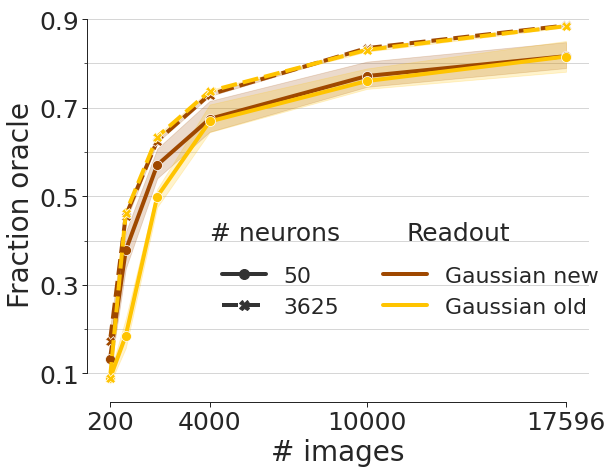

In [48]:
scoring_measure = "fraction_oracle"
palette = [col for i, col in enumerate(sns.color_palette('bright')) if i in (5,8) ]

title = 'Direct training - readout comparison'
    
paper_rc = {'lines.linewidth': 4, 'lines.markersize': 10}  
with sns.plotting_context('paper', rc=paper_rc, font_scale=2.15), sns.color_palette('bright'), sns.axes_style('ticks'):     
    
    g = sns.relplot(x="# images", 
                    y=scoring_measure,
                    hue="Readout", 
                    style="# neurons",
                    kind="line",
                    data=data,
                    markers=True,
                    height=7,
                    aspect=0.9,
                    palette=palette) 
    
    ax = g.axes[0, 0]
    
    ax.set_xticks(np.unique(data['# images'])[[0, 3, 4, 5]])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xlabel("# images", fontsize=28)
    ax.set_ylabel(scoring_measure.replace('_', ' ').capitalize(), fontsize=28)
    ax.tick_params(labelsize=25)
    ax.set_yticks([.1, .3, .5, .7, .9])
    ax.set_yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9], minor=True)
    ax.yaxis.grid(which='major')
    ax.yaxis.grid(which='minor')
    sns.despine(trim=True)
    plt.tight_layout()
    
    idx = [4, 5, 1, 2]
    h, l = ax.get_legend_handles_labels()
    h = [h[i] for i in idx]
    l = [l[i].capitalize() for i in idx]
    g._legend.remove()
    g.fig.legend(h,l, ncol=2, frameon=False, bbox_to_anchor=(0.45, 0.25, 0.5, 0.2), fontsize=22)
    
    # add title to the legend
    ax.text(4000, .4, "# neurons", fontsize=25, )
    ax.text(11500, .4, "Readout", fontsize=25)
    
    #g.fig.savefig('figures/' + title.title().replace(" ", "").replace(",", "-") + '.pdf', dpi=150, bbox_inches='tight')

### Task driven stuff

In [213]:
model_name = 'taskdriven_fullgaussian2d'
paths = ['data/static20457-5-9-preproc0.zip']
detach_core = True

experiment_name = 'Real, taskdriven transfer (random VGG), {}, 20457-5-9'.format(model_name)
experiment_comment = 'Transfer learning (random VGG) on real data with {} and static_loaders of 20457-5-9. Varying number of images.'.format(model_name)
fabrikant_name = 'kklurz'

model_fn = "nnsysident.models.models.{}".format(model_name)
dataset_fn = 'nnsysident.datasets.mouse_loaders.static_loaders'

dataset = pd.DataFrame((Dataset & 'dataset_fn = "{}"'.format(dataset_fn)).fetch())
dataset = pd.concat([dataset, dataset['dataset_config'].apply(pd.Series)], axis = 1)
dataset = dataset.loc[~dataset['exclude'].isnull()]
dataset = dataset.loc[[np.isin(row['paths'], [paths])[0] for loc, row in dataset.iterrows()]]
dataset = dataset.loc[(dataset['neuron_n'] == 5335)].sort_values('image_n') # maybe comment here

model = pd.DataFrame((Model & 'model_fn="{}"'.format(model_fn)).fetch())
for arg in ['neuron_n', 'multi_match_n', 'image_n']:
    model[arg] = [find_number(row.model_comment, arg + '=') for loc, row in model.iterrows()]
model = pd.concat([model, model['model_config'].apply(pd.Series)], axis = 1)

model = model.loc[model['multi_match_n'].isnull()] # maybe comment this
model = model.loc[model['neuron_n'] == 5335] # maybe comment this
model = model.loc[~model['grid_mean_predictor'].isnull()]
model = model.loc[model['pretrained'] == False]

trainer = pd.DataFrame((Trainer & 'trainer_fn="{}"'.format(trainer_fn)).fetch())
trainer = pd.concat([trainer, trainer['trainer_config'].apply(pd.Series)], axis = 1)
trainer = trainer.loc[(trainer['detach_core'] == detach_core)]    
assert len(trainer) == 1, 'Too many trainers!'

combinations = pd.merge(dataset, model, on=["neuron_n", "image_n"]).sort_values(['neuron_n', 'image_n'])
   
experiment = [{'dataset_hash': row['dataset_hash'], 
               'dataset_fn': row['dataset_fn'],
               'model_hash': row['model_hash'],
               'model_fn': row['model_fn'],
               'trainer_hash': trainer['trainer_hash'].values[0],
               'trainer_fn': trainer['trainer_fn'].values[0],
                 'experiment_name': experiment_name} for loc, row in combinations.iterrows()]

# Experiments.insert1(dict(experiment_name=experiment_name, experiment_fabrikant=fabrikant_name, experiment_comment=experiment_comment))
# Experiments.Restrictions.insert(experiment, skip_duplicates=True)